[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/Traffic_.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/DS/Practice/MRCNN

/content/drive/My Drive/DS/Practice/MRCNN


In [ ]:
!pip install tensorflow-gpu==1.15.3
!pip install keras==2.2.4

In [ ]:
import math
import os
import random
import re
import sys
import time
import xml.etree

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray, zeros

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import mrcnn.config
import mrcnn.model
import mrcnn.model as modellib
import mrcnn.utils
from matplotlib.patches import Polygon
from mrcnn import utils, visualize
from mrcnn.config import Config
from mrcnn.model import log
from mrcnn.visualize import display_images

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


#Get_class_name

In [ ]:
TRAFFIC_SIGN_DIR = os.path.join(ROOT_DIR, "datasets/traffic_sign_train")

In [ ]:
TRAFFIC_SIGN_VALID_DIR = os.path.join(ROOT_DIR, "datasets/traffic_sign_valid")

In [ ]:
TRAFFIC_SIGN_TEST_DIR = os.path.join(ROOT_DIR, "datasets/traffic_sign_test")

In [ ]:
def get_class_names(dataset_dir):
    annotations_dir = TRAFFIC_SIGN_DIR + "/annots/"
    classNames = set()
    for filename in os.listdir(annotations_dir):
        tree = xml.etree.ElementTree.parse(annotations_dir + filename)

        root = tree.getroot()

        for box in root.findall(".//objects"):
            name = box.find("category").text
            classNames.add(name)
    return list(classNames)

In [ ]:
classNames = get_class_names(TRAFFIC_SIGN_DIR)

#Configuration

In [ ]:
class TraficSignConfig(Config):
    NAME = "traffic_sign_cfg"
    STEPS_PER_EPOCH = 131
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # number of classes (we would normally add +1 for the background)
    NUM_CLASSES = 1 + 90

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131

    # Learning rate
    LEARNING_RATE = 0.0006

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    # setting Max ground truth instances
    MAX_GT_INSTANCES = 10

In [ ]:
config = TraficSignConfig()
config.display()

#Dataset

In [ ]:
class TrafficSignDataset(mrcnn.utils.Dataset):
    def __init__(self):
        self.classNames = []
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def load_dataset(self, dataset_dir, classNames):
        for idx, elements in enumerate(classNames):
            self.add_class("dataset", idx + 1, elements)
            self.classNames.append(elements)

        images_dir = dataset_dir + "/images/"
        annotations_dir = dataset_dir + "/annots/"

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + ".xml"

            self.add_image(
                "dataset", image_id=image_id, path=img_path, annotation=ann_path
            )

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall(".//objects"):
            name = box.find("category").text
            xmin = int(float(box.find("./bbox/xmin").text))
            ymin = int(float(box.find("./bbox/ymin").text))
            xmax = int(float(box.find("./bbox/xmax").text))
            ymax = int(float(box.find("./bbox/ymax").text))
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)

        width = int(root.find(".//size/width").text)
        height = int(root.find(".//size/height").text)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info["annotation"]
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype="uint8")

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]

            for idx, elements in enumerate(self.classNames):
                if box[4] == elements:
                    masks[row_s:row_e, col_s:col_e, i] = idx + 1
                    class_ids.append(self.class_names.index(elements))
                    break
        return masks, asarray(class_ids, dtype="int32")

In [ ]:
train_set = TrafficSignDataset()
train_set.load_dataset(dataset_dir=TRAFFIC_SIGN_DIR, classNames=classNames)
train_set.prepare()

In [ ]:
valid_dataset = TrafficSignDataset()
valid_dataset.load_dataset(dataset_dir=TRAFFIC_SIGN_VALID_DIR, classNames=classNames)
valid_dataset.prepare()

In [ ]:
test_set = TrafficSignDataset()
test_set.load_dataset(dataset_dir=TRAFFIC_SIGN_TEST_DIR, classNames=classNames)
test_set.prepare()

#Show sample

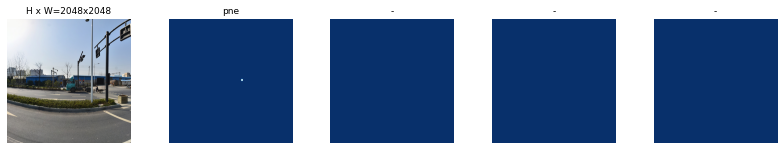

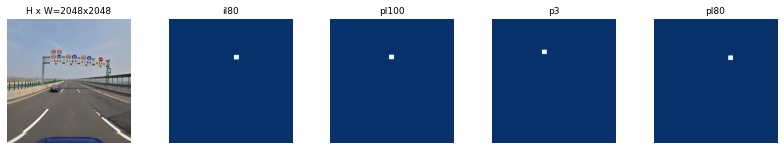

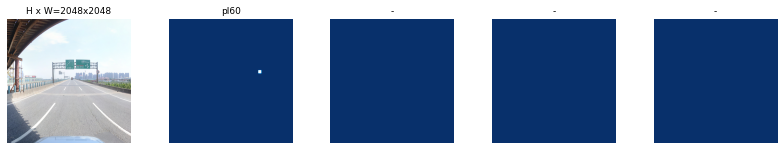

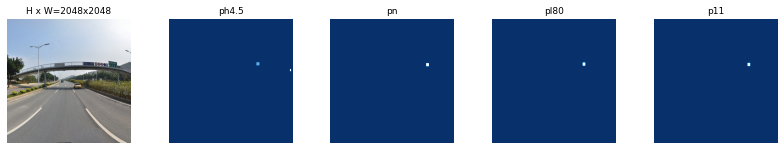

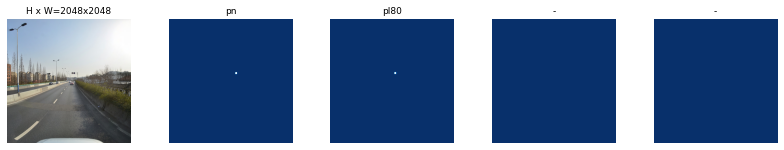

In [ ]:
image_ids = np.random.choice(train_set.image_ids, 5)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

#Bounding Box

In [ ]:
# Load random image and mask.
image_id = np.random.choice(train_set.image_ids, 1)[0]
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#Resize image

In [ ]:
image_id = np.random.choice(train_set.image_ids, 1)[0]
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE,
)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, train_set.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

#Mini Mask

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (103,)                min:    0.00000  max: 2048.00000  float64
class_ids                shape: (3,)                  min:   18.00000  max:   84.00000  int32
bbox                     shape: (3, 4)                min:  439.00000  max:  922.00000  int32
mask                     shape: (1024, 1024, 3)       min:    0.00000  max:   84.00000  uint8


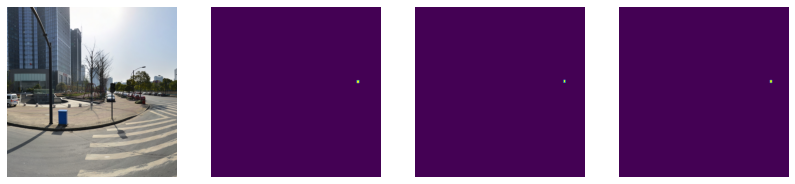

In [ ]:
image_id = np.random.choice(train_set.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    train_set, config, image_id, use_mini_mask=False
)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image] + [mask[:, :, i] for i in range(min(mask.shape[-1], 7))])

#Create Model

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [ ]:
model.load_weights(
    COCO_MODEL_PATH,
    by_name=True,
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"],
)

#Train Model

In [ ]:
model.train(
    train_dataset=train_set,
    val_dataset=valid_dataset,
    learning_rate=config.LEARNING_RATE,
    epochs=700,
    layers="heads",
)

#Save weight

In [ ]:
model_path = '/content/drive/My Drive/DS/Practice/MRCNN/Traffic_Sign_Detection/after_700_epochs.h5'
model.keras_model.save_weights(model_path)

#Visualize Loss

#mrcnn_class_loss

- After 900 epochs

In [ ]:
fig = plt.figure()
# plot mrcnn_class_loss and val_mrcnn_class_loss
plt.plot(model.keras_model.history.history["mrcnn_class_loss"])
plt.plot(model.keras_model.history.history["val_mrcnn_class_loss"])
plt.xlabel("Epochs")
plt.ylabel("mrcnn_class and val_mrcnn_loss")
plt.title("mrcnn_class_loss")
plt.legend(["train", "val"])
plt.show()

#rpn_class_loss

- After 900 epochs

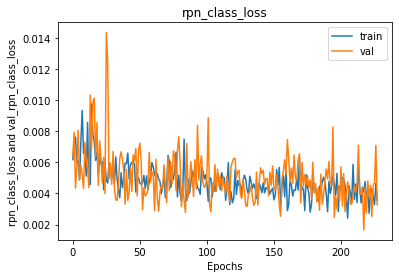

In [ ]:
fig = plt.figure()
# plot rpn_class_loss and val_rpn_class_loss
plt.plot(model.keras_model.history.history['rpn_class_loss'])
plt.plot(model.keras_model.history.history['val_rpn_class_loss'])
plt.xlabel('Epochs')
plt.ylabel('rpn_class_loss and val_rpn_class_loss')
plt.title('rpn_class_loss')
plt.legend(['train', 'val'])
plt.show()

- After 700 epochs

In [ ]:
fig = plt.figure()
# plot rpn_class_loss and val_rpn_class_loss
plt.plot(model.keras_model.history.history['rpn_class_loss'])
plt.plot(model.keras_model.history.history['val_rpn_class_loss'])
plt.xlabel('Epochs')
plt.ylabel('rpn_class_loss and val_rpn_class_loss')
plt.title('rpn_class_loss')
plt.legend(['train', 'val'])
plt.show()

#Loss

- After 700 epochs

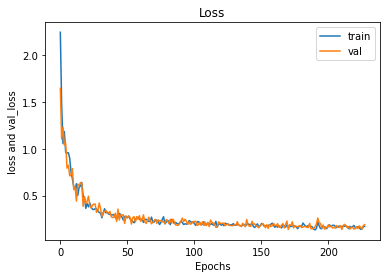

In [ ]:
fig = plt.figure()
# plot loss and val_loss
plt.plot(model.keras_model.history.history['loss'])
plt.plot(model.keras_model.history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('loss and val_loss')
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

#rpn_bbox_loss

- After 700 epochs

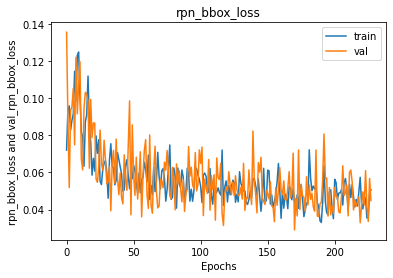

In [ ]:
fig = plt.figure()
# plot rpn_bbox_loss and val_rpn_bbox_loss
plt.plot(model.keras_model.history.history['rpn_bbox_loss'])
plt.plot(model.keras_model.history.history['val_rpn_bbox_loss'])
plt.xlabel('Epochs')
plt.ylabel('rpn_bbox_loss and val_rpn_bbox_loss')
plt.title('rpn_bbox_loss')
plt.legend(['train', 'val'])
plt.show()

#mrcnn_bbox_loss

- After 700 epochs

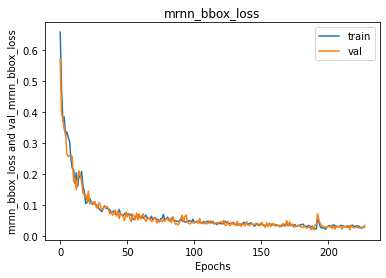

In [ ]:
fig = plt.figure()
# plot mrcnn_bbox_loss and val_mrcnn_bbox_loss
plt.plot(model.keras_model.history.history['mrcnn_bbox_loss'])
plt.plot(model.keras_model.history.history['val_mrcnn_bbox_loss'])
plt.xlabel('Epochs')
plt.ylabel('mrnn_bbox_loss and val_mrnn_bbox_loss')
plt.title('mrnn_bbox_loss')
plt.legend(['train', 'val'])
plt.show()

#mrncc_mask_loss

- After 700 epochs

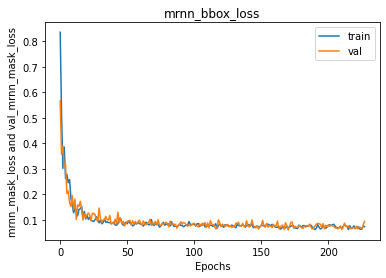

In [ ]:
fig = plt.figure()
# plot mrcnn_mask_loss and val_mrcnn_mask_loss
plt.plot(model.keras_model.history.history['mrcnn_mask_loss'])
plt.plot(model.keras_model.history.history['val_mrcnn_mask_loss'])
plt.xlabel('Epochs')
plt.ylabel('mrnn_mask_loss and val_mrnn_mask_loss')
plt.title('mrnn_bbox_loss')
plt.legend(['train', 'val'])
plt.show()

#Load weight

In [ ]:
model1 = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

model1.load_weights(model_path, by_name=True)

#Detection

#1

- Actual

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
image_meta               shape: (103,)                min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (9,)                  min:   20.00000  max:   82.00000  int32
gt_bbox                  shape: (9, 4)                min:   10.00000  max:  373.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:   82.00000  uint8


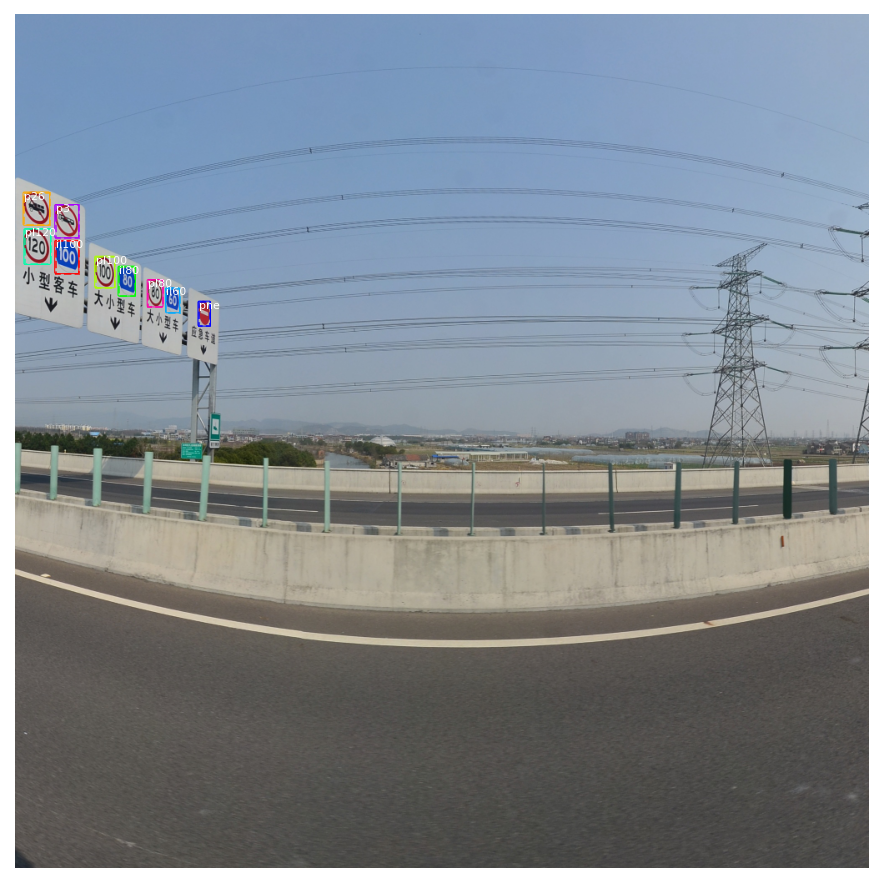

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(
    test_set, config, image_id, use_mini_mask=False
)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(
    original_image,
    gt_bbox,
    gt_mask,
    gt_class_id,
    test_set.class_names,
    figsize=(16, 16),
)

- Predict

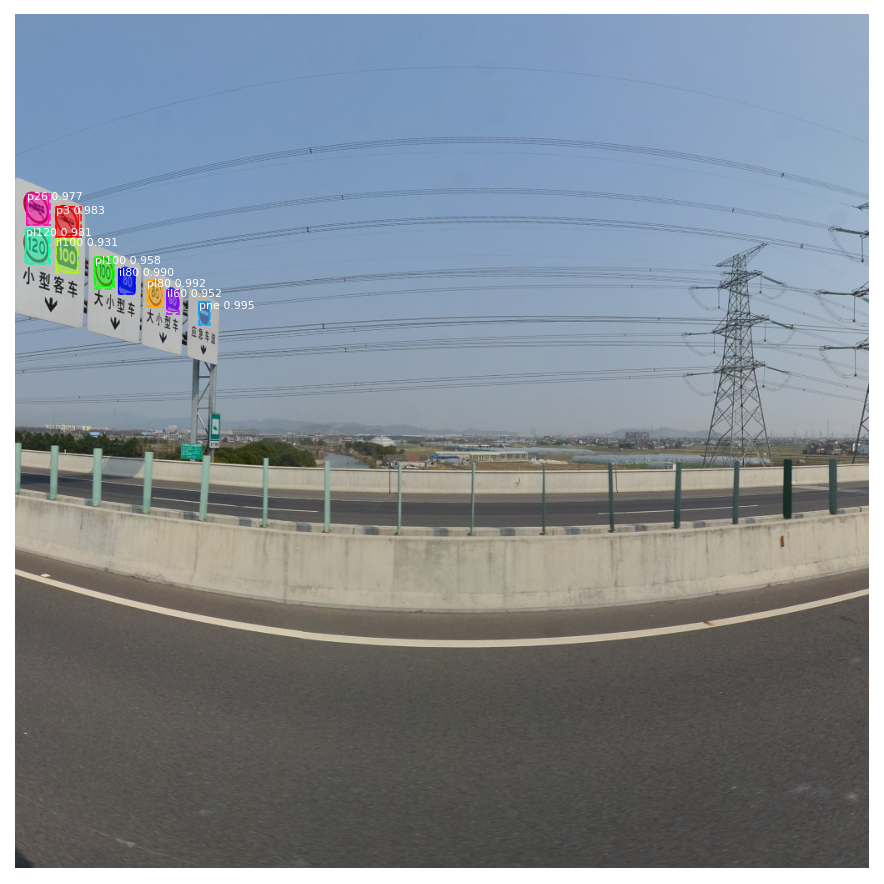

In [ ]:
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(
    image=original_image,
    boxes=r["rois"],
    masks=r["masks"],
    class_ids=r["class_ids"],
    class_names=test_set.class_names,
    scores=r["scores"],
    figsize=(16, 16),
)

#2

- Actual

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (103,)                min:    0.00000  max: 2048.00000  float64
gt_class_id              shape: (1,)                  min:   88.00000  max:   88.00000  int32
gt_bbox                  shape: (1, 4)                min:  509.00000  max:  743.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:   88.00000  uint8


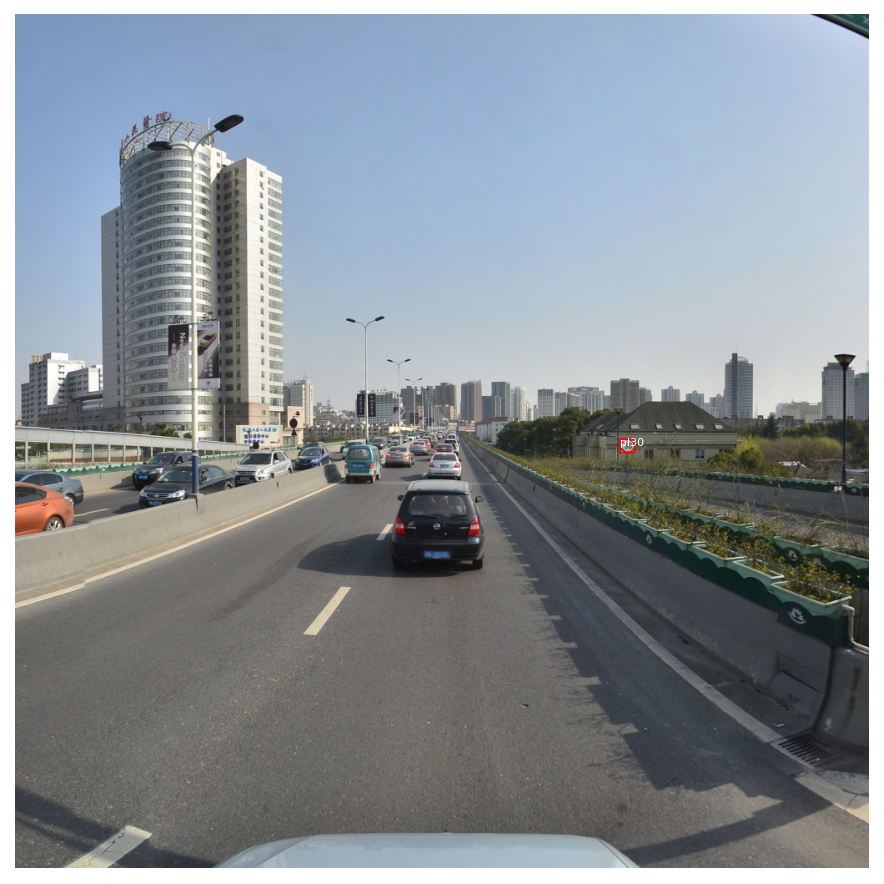

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

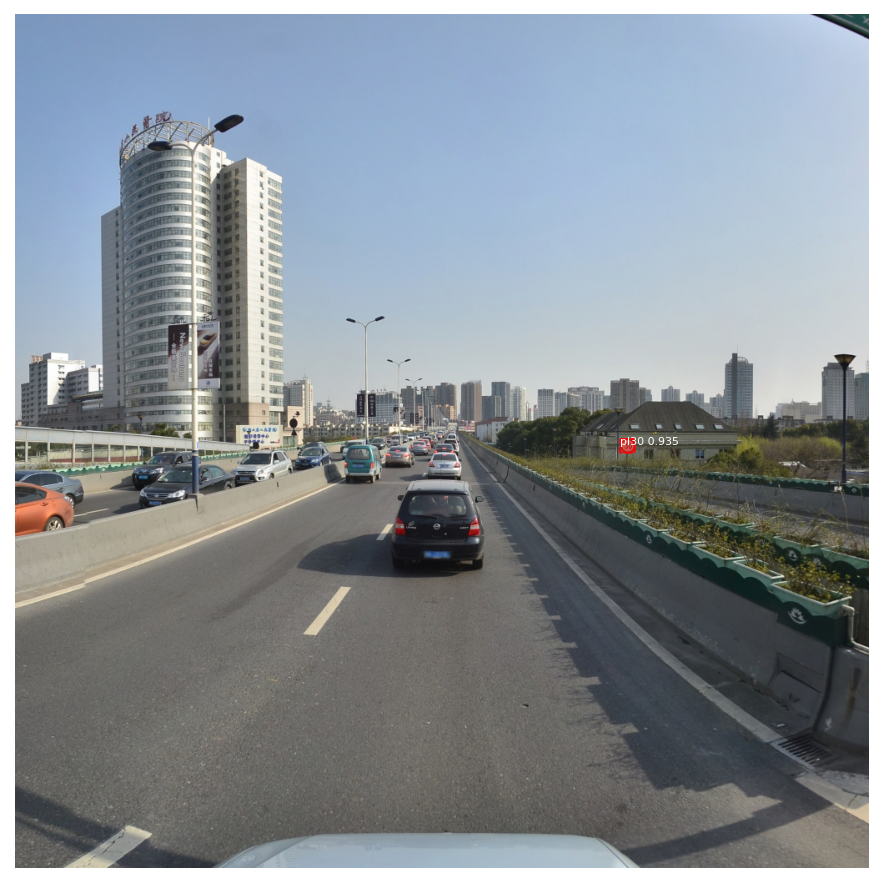

In [ ]:
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#3

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#4

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#5

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#6

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#7

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#8

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#9

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#10

- Actual

In [ ]:
# Test on a random image
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            test_set.class_names, figsize=(16, 16))

- Predict

In [ ]:
# Perform a forward pass of the network to obtain the results
r = model1.detect([original_image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
visualize.display_instances(image=original_image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'],
                                  class_names=test_set.class_names,
                                  scores=r['scores'],
                                  figsize=(16, 16))

#Evaluate

In [ ]:
image_ids = np.random.choice(test_set.image_ids, test_set.num_images)
APs = []
pre = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(test_set, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model1.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8854657691536527
